In [90]:
import matplotlib.pyplot as plt
import numpy as np
gen = np.random.default_rng()

In [264]:
A = [1, 2, 3]
B = [3, 1, 2]
categories = ["chores", "finances", "activities"]
# strategies = ["always insist", "always compromise", "tit for tat", "grim trigger", "gradual forgiving", "random"]


def insist(x):
    return [0,0,0]


def compromise(x):
    return [1,1,1]

def random(x):
    return gen.integers(2, size=3)

def tft(x):
    if x == []:
        return [1,1,1]
    return x[-1]


In [265]:
def single_payoff(payoffs, choice_A, choice_B):
    return payoffs[choice_A, choice_B]


def payoffs(i):
    ret = np.array([[[0, 0], [A[i], -B[i]]],
                    [[-A[i], B[i]], [1.5, 1.5]]])
    return ret

In [266]:
def game(strategy_A, strategy_B, N=10):
    choices = [[], []]
    for i in range(N):
        a = strategy_A(choices[1])
        b = strategy_B(choices[0])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

In [269]:
choices = game(tft, random)
print(np.shape(choices))

(3, 10, 2)


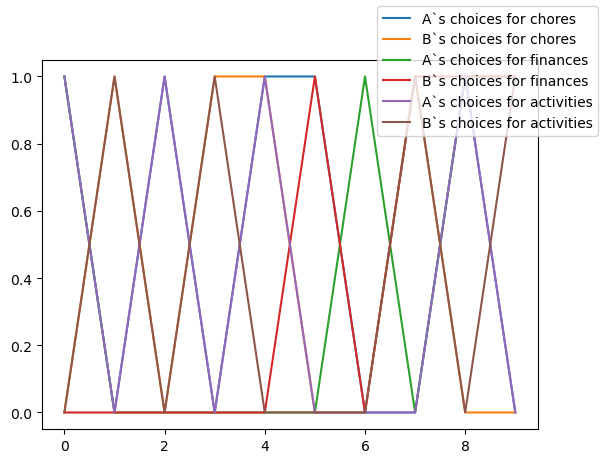

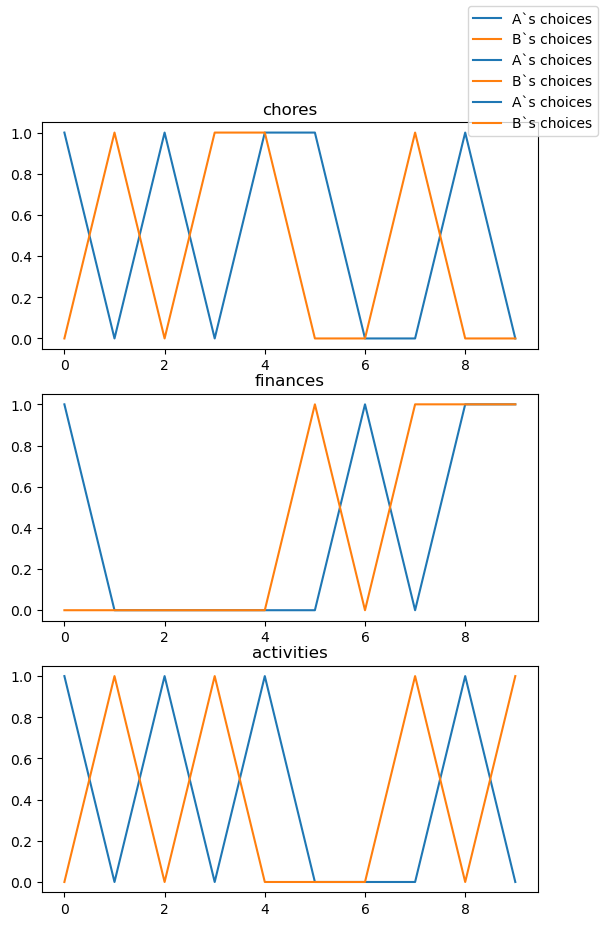

In [270]:
fig, ax = plt.subplots()
for i in range(3):
    ax.plot(choices[i], label = [f'A`s choices for {categories[i]}', f'B`s choices for {categories[i]}'])
fig.legend()
plt.show()

fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i],label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()